In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as img
from PIL import Image
from skimage.measure import block_reduce

In [3]:
play_im0_original = Image.open("./changedetection2017/playground/images/Image0.JPG")
play_im0 = np.asarray(play_im0_original, dtype="float32")
play_im0 = play_im0 / 255.0

play_im0_noisy = play_im0 + np.random.normal(loc=0, scale=0.1, size=play_im0.shape)

play_im1_original = Image.open("./changedetection2017/playground/images/Image2.JPG")
play_im1 = np.asarray(play_im1_original, dtype="float32")
play_im1 = play_im1 / 255.0

stat_im0_original = Image.open("./changedetection2017/statue/images/Image0.JPG")
stat_im0 = np.asarray(stat_im0_original, dtype="float32")
stat_im0 = stat_im0 / 255.0

In [4]:
results = {
  "noise_baseline":   [np.mean( (play_im0 - play_im0_noisy)**2 )],
  "other_angle":      [np.mean( (play_im0 - play_im1)**2 )],
  "other_image":      [np.mean( (play_im0 - stat_im0)**2 )]
}

for blocksize in range(2,200):
  play_im0_red = block_reduce(play_im0, block_size=(blocksize, blocksize, 1), func=np.mean)
  play_im0_noisy_red = block_reduce(play_im0_noisy, block_size=(blocksize, blocksize, 1), func=np.mean)
  play_im1_red = block_reduce(play_im1, block_size=(blocksize, blocksize, 1), func=np.mean)
  stat_im0_red = block_reduce(stat_im0, block_size=(blocksize, blocksize, 1), func=np.mean)

  results["noise_baseline"].append( np.mean( (play_im0_red - play_im0_noisy_red)**2 ) )
  results["other_angle"].append( np.mean( (play_im0_red - play_im1_red)**2 ) )
  results["other_image"].append( np.mean( (play_im0_red - stat_im0_red)**2 ) )

KeyboardInterrupt: 

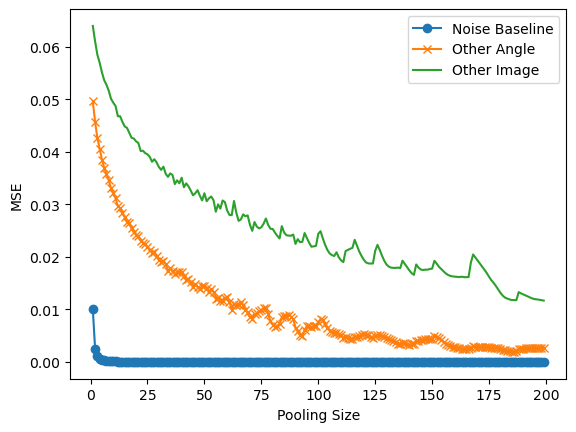

In [ ]:
plt.plot(range(1,len(results['noise_baseline'])+1), results['noise_baseline'], "o-", label="Noise Baseline")
plt.plot(range(1,len(results['noise_baseline'])+1), results['other_angle'], "x-", label="Other Angle")
plt.plot(range(1,len(results['noise_baseline'])+1), results['other_image'], label="Other Image")
plt.legend()
plt.xlabel("Pooling Size")
plt.ylabel("MSE")
plt.show()

### Desk Dataset

In [5]:
normal_img0_original = Image.open("./desk-dataset/IMG_9360.jpg")
normal_img1_original = Image.open("./desk-dataset/IMG_9359.jpg")
moved_img0_original = Image.open("./desk-dataset/IMG_9362.jpg")

normal_img0 = np.asarray(normal_img0_original, dtype="float32")
normal_img1 = np.asarray(normal_img1_original, dtype="float32")
moved_img0 = np.asarray(moved_img0_original, dtype="float32")

normal_img0 = normal_img0 / 255.0
normal_img1 = normal_img1 / 255.0
moved_img0 = moved_img0 / 255.0

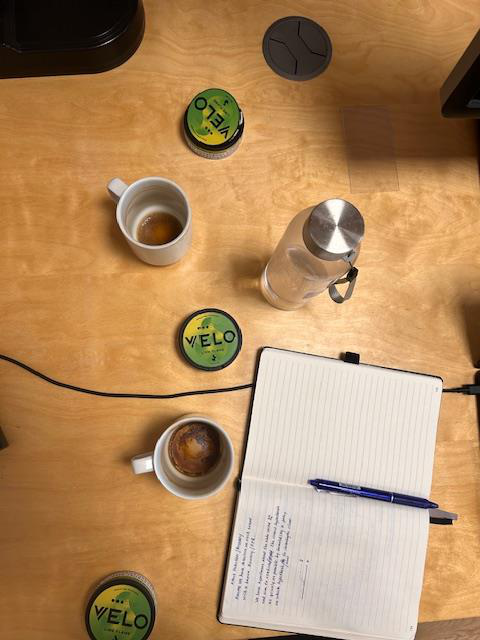

In [50]:
Image.fromarray(np.asarray(normal_img0*255, dtype="uint8"))

In [6]:
def jpg_to_numpy(path):
  img = Image.open(path)
  img = np.asarray(img, dtype="float32")
  img = img / 255.0

  return img

#### Augment Desk Dataset

In [61]:
import random
import cv2
from typing import Tuple, List, Callable
import os

def _rand_uniform(a: float, b: float) -> float:
    return random.uniform(a, b)

def random_gaussian_noise(img: np.ndarray, sigma: float = 0.001, p: float = 0.5) -> np.ndarray:
    if random.random() < p:
        noise = np.random.normal(0, sigma, img.shape).astype(np.float32)
        img = np.clip(img + noise, 0, 1)
    return img


def random_blur(img: np.ndarray, ksize: Tuple[int, int] = (3, 3), p: float = 0.5) -> np.ndarray:
    if random.random() < p:
        kx = random.choice(range(ksize[0] | 1, ksize[0] + 2, 2))  # ensure odd
        ky = random.choice(range(ksize[1] | 1, ksize[1] + 2, 2))
        img = cv2.GaussianBlur(img, (kx, ky), 0)
    return img

def random_crop_resize(img: np.ndarray, scale: Tuple[float, float] = (0.8, 1.0),
                        ratio: Tuple[float, float] = (3. / 4., 4. / 3.),
                        target_size: Tuple[int, int] = None, p: float = 0.5) -> np.ndarray:
    """Random crop & resize similar to torchvision's RandomResizedCrop."""
    if random.random() >= p:
        return img

    h, w = img.shape[:2]
    area = h * w
    for _ in range(10):
        target_area = area * _rand_uniform(*scale)
        log_ratio = np.log(ratio)
        aspect_ratio = np.exp(_rand_uniform(*log_ratio))

        nw = int(round(np.sqrt(target_area * aspect_ratio)))
        nh = int(round(np.sqrt(target_area / aspect_ratio)))

        if 0 < nw <= w and 0 < nh <= h:
            x1 = random.randint(0, w - nw)
            y1 = random.randint(0, h - nh)
            img_crop = img[y1:y1 + nh, x1:x1 + nw]
            if target_size is None:
                target_size = (w, h)
            img_crop = cv2.resize(img_crop, (target_size[0], target_size[1]), interpolation=cv2.INTER_LINEAR)
            return img_crop
    # Fallback
    return img

def compose(transforms: List[Callable[[np.ndarray], np.ndarray]]) -> Callable[[np.ndarray], np.ndarray]:
    """Compose a list of augmentation functions into one."""
    def _func(img_path: str) -> np.ndarray:
        img = np.asarray(Image.open(img_path), dtype="float32")
        img = img / 255.0
        for t in transforms:
            img = t(img)
        return img
    return _func

def pipeline(dir, n_iters=10):
    
    for i in range(n_iters):

        for filename in os.listdir(dir):
            path = dir + filename
            augment = compose([random_gaussian_noise, random_blur, random_crop_resize])
            img = augment(path)
            img = Image.fromarray(np.asarray(img*255, dtype="uint8"))
            img.save(f"./aug-desk-dataset/{filename[:-4]}_{i}.jpg", format="JPEG")

In [62]:
pipeline("./desk-dataset/", n_iters=20)

#### Algorithms

In [30]:
results = {
  "same-order": [np.mean( (normal_img0 - normal_img1)**2 )],
  "coffee-moved": [np.mean( (normal_img0 - moved_img0)**2 )],
}

blocksizes = [2, 4, 8, 16, 32, 64, 128]

for blocksize in blocksizes:
  normal_img0_red = block_reduce(normal_img0, block_size=(blocksize, blocksize, 1), func=np.mean)
  normal_img1_red = block_reduce(normal_img1, block_size=(blocksize, blocksize, 1), func=np.mean)
  moved_img0_red = block_reduce(moved_img0, block_size=(blocksize, blocksize, 1), func=np.mean)

  results['same-order'].append( np.mean( (normal_img0_red - normal_img1_red)**2 ) )
  results['coffee-moved'].append( np.mean( (normal_img0_red - moved_img0_red)**2 ) )

In [31]:
margin = 0.4
thresholds = np.array( results['same-order'] )+ margin*(np.array(results["coffee-moved"]) - np.array(results['same-order'])) 

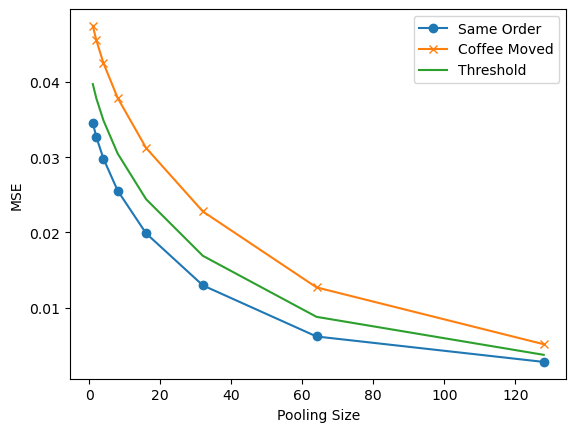

In [32]:
plt.plot([1] + blocksizes, results['same-order'], "o-", label="Same Order")
plt.plot([1] + blocksizes, results['coffee-moved'], "x-", label="Coffee Moved")
plt.plot([1] + blocksizes, thresholds, label="Threshold")
plt.legend()
plt.xlabel("Pooling Size")
plt.ylabel("MSE")
plt.show()

In [68]:
def classifier(thresholds: np.ndarray, mses: np.ndarray):
  decisions = mses > thresholds

  return 1 if decisions.sum() > len(decisions)*0.5 else 0

def change_detection(image1, image2, thresholds, blocksizes):
  errors = [ np.mean( (image1-image2)**2 ) ]
  
  for blocksize in blocksizes:
    image1_red = block_reduce(image1, block_size=(blocksize, blocksize, 1), func=np.mean)
    image2_red = block_reduce(image2, block_size=(blocksize, blocksize, 1), func=np.mean)

    errors.append( np.mean( (image1_red - image2_red)**2 ) )
  
  return classifier(thresholds, errors)

def change_detection_fixed_blocksize_score(image1, image2, blocksize):
  if blocksize == 1: return np.mean( (image1-image2)**2 )

  image1_red = block_reduce(image1, block_size=(blocksize, blocksize, 1), func=np.mean)
  image2_red = block_reduce(image2, block_size=(blocksize, blocksize, 1), func=np.mean)

  return np.mean( (image1_red-image2_red)**2 )


In [67]:
from itertools import combinations
import os

img_combs = list(combinations(os.listdir("./aug-desk-dataset/"), 2))

def is_same(image_pair):
  im1_id = image_pair[0][6:8]
  im2_id = image_pair[1][6:8]

  if int(im1_id) in {58, 59, 60, 61} and int(im2_id) in {58, 59, 60, 61}:
    return True
  
  return False

dataset = {"image-pair": [], "label": []}
for idx, comb in enumerate(img_combs):
  dataset["image-pair"].append(comb)
  dataset["label"].append(is_same(comb))

ROC-AUC: 0.5875813436623969


Text(0.5, 1.0, 'ROC-Curve Pixel Comparision Kernel Size: 1')

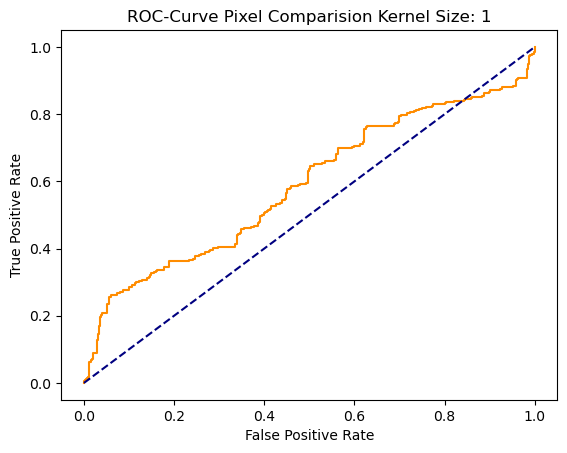

In [86]:
# Finding Thresholds for fixed kernelsize detectors
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, roc_curve, roc_auc_score

predictions = []
labels = []
random_indexes = [np.random.randint(len(dataset['image-pair'])) for _ in range(1000)]

for idx in random_indexes:
  im1 = jpg_to_numpy("./aug-desk-dataset/" + dataset['image-pair'][idx][0])
  im2 = jpg_to_numpy("./aug-desk-dataset/" + dataset['image-pair'][idx][1])
  labels.append(dataset['label'][idx])
  dec = change_detection_fixed_blocksize_score(im1, im2, blocksize=1)
  predictions.append(dec)


roc = roc_curve(labels, predictions)
print("ROC-AUC:", roc_auc_score(labels, predictions))

plt.plot(roc[0], roc[1], color="darkorange")
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-Curve Pixel Comparision Kernel Size: 1")

ROC-AUC: 0.5666309523809524


Text(0.5, 1.0, 'ROC-Curve Pixel Comparision Kernel Size: 2')

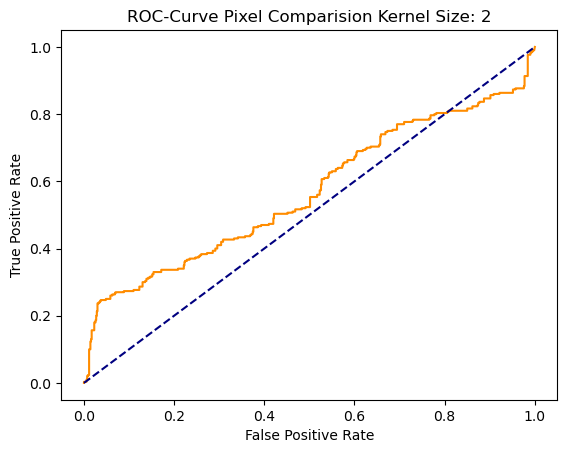

In [87]:
predictions = []
labels = []
random_indexes = [np.random.randint(len(dataset['image-pair'])) for _ in range(1000)]

for idx in random_indexes:
  im1 = jpg_to_numpy("./aug-desk-dataset/" + dataset['image-pair'][idx][0])
  im2 = jpg_to_numpy("./aug-desk-dataset/" + dataset['image-pair'][idx][1])
  labels.append(dataset['label'][idx])
  dec = change_detection_fixed_blocksize_score(im1, im2, blocksize=2)
  predictions.append(dec)


roc = roc_curve(labels, predictions)
print("ROC-AUC:", roc_auc_score(labels, predictions))
plt.plot(roc[0], roc[1], color="darkorange")
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-Curve Pixel Comparision Kernel Size: 2")

ROC-AUC: 0.5990209196970492


Text(0.5, 1.0, 'ROC-Curve Pixel Comparision Kernel Size: 4')

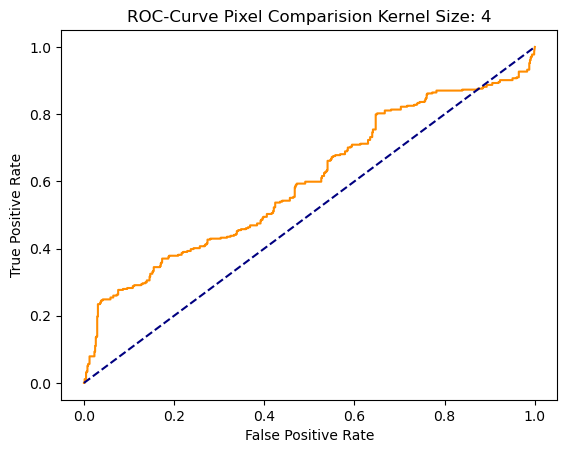

In [88]:
predictions = []
labels = []
random_indexes = [np.random.randint(len(dataset['image-pair'])) for _ in range(1000)]

for idx in random_indexes:
  im1 = jpg_to_numpy("./aug-desk-dataset/" + dataset['image-pair'][idx][0])
  im2 = jpg_to_numpy("./aug-desk-dataset/" + dataset['image-pair'][idx][1])
  labels.append(dataset['label'][idx])
  dec = change_detection_fixed_blocksize_score(im1, im2, blocksize=4)
  predictions.append(dec)


roc = roc_curve(labels, predictions)
print("ROC-AUC:", roc_auc_score(labels, predictions))
plt.plot(roc[0], roc[1], color="darkorange")
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-Curve Pixel Comparision Kernel Size: 4")

ROC-AUC: 0.5602847589256823


Text(0.5, 1.0, 'ROC-Curve Pixel Comparision Kernel Size: 8')

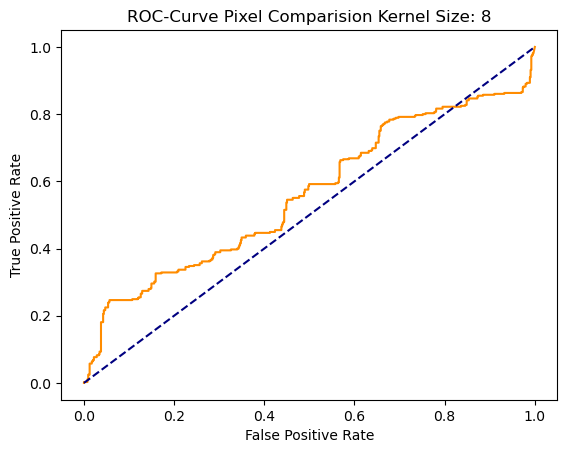

In [89]:
predictions = []
labels = []
random_indexes = [np.random.randint(len(dataset['image-pair'])) for _ in range(1000)]

for idx in random_indexes:
  im1 = jpg_to_numpy("./aug-desk-dataset/" + dataset['image-pair'][idx][0])
  im2 = jpg_to_numpy("./aug-desk-dataset/" + dataset['image-pair'][idx][1])
  labels.append(dataset['label'][idx])
  dec = change_detection_fixed_blocksize_score(im1, im2, blocksize=8)
  predictions.append(dec)


roc = roc_curve(labels, predictions)
print("ROC-AUC:", roc_auc_score(labels, predictions))
plt.plot(roc[0], roc[1], color="darkorange")
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-Curve Pixel Comparision Kernel Size: 8")

ROC-AUC: 0.5423350314764608


Text(0.5, 1.0, 'ROC-Curve Pixel Comparision Kernel Size: 16')

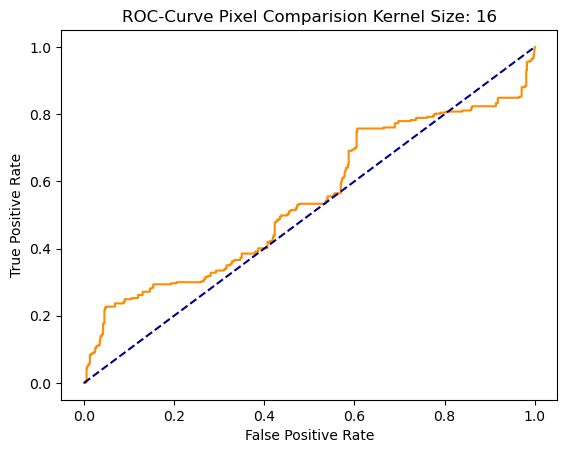

In [90]:
predictions = []
labels = []
random_indexes = [np.random.randint(len(dataset['image-pair'])) for _ in range(1000)]

for idx in random_indexes:
  im1 = jpg_to_numpy("./aug-desk-dataset/" + dataset['image-pair'][idx][0])
  im2 = jpg_to_numpy("./aug-desk-dataset/" + dataset['image-pair'][idx][1])
  labels.append(dataset['label'][idx])
  dec = change_detection_fixed_blocksize_score(im1, im2, blocksize=16)
  predictions.append(dec)


roc = roc_curve(labels, predictions)
print("ROC-AUC:", roc_auc_score(labels, predictions))
plt.plot(roc[0], roc[1], color="darkorange")
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-Curve Pixel Comparision Kernel Size: 16")

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score


predictions = []

for im_pair, label in zip(dataset['image-pair'], dataset['label']):
  im1 = jpg_to_numpy("./aug-desk-dataset/"+im_pair[0])
  im2 = jpg_to_numpy("./aug-desk-dataset/"+im_pair[1])

  dec = change_detection(im1, im2, thresholds, blocksizes)
  predictions.append(dec)

print("Accuracy:", accuracy_score(dataset['label'], predictions))
print("Precision:", precision_score(dataset['label'], predictions))
print("Recall:", recall_score(dataset['label'], predictions))

cm = confusion_matrix(dataset['label'], predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Same Image", "Different Image"])
disp.plot()

KeyboardInterrupt: 

In [ ]:
import imagehash

def dhash_score(im1, im2):
  return imagehash.dhash(im1, hash_size=8) - imagehash.dhash(im2, hash_size=8)

In [94]:
from sklearn.metrics import roc_curve

predictions = []
scores = []
labels = []

random_indexes = [np.random.randint(len(dataset['image-pair'])) for _ in range(1000)]

for idx in random_indexes:
  im1 = Image.open("./aug-desk-dataset/" + dataset['image-pair'][idx][0])
  im2 = Image.open("./aug-desk-dataset/" + dataset['image-pair'][idx][1])
  labels.append(dataset['label'][idx])

  score = dhash_score(im1, im2)
  scores.append(score)

  predictions.append( score >= 18)

# print("Accuracy:", accuracy_score(labels, predictions))
# print("Precision:", precision_score(labels, predictions))
# print("Recall:", recall_score(labels, predictions))

# cm = confusion_matrix(labels, predictions)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Same Image", "Different Image"])
# disp.plot()

roc = roc_curve(labels, scores)
print("ROC-AUC:", roc_auc_score(labels, scores))

ROC-AUC: 0.5416574448071709


Text(0, 0.5, 'True Positive Rate')

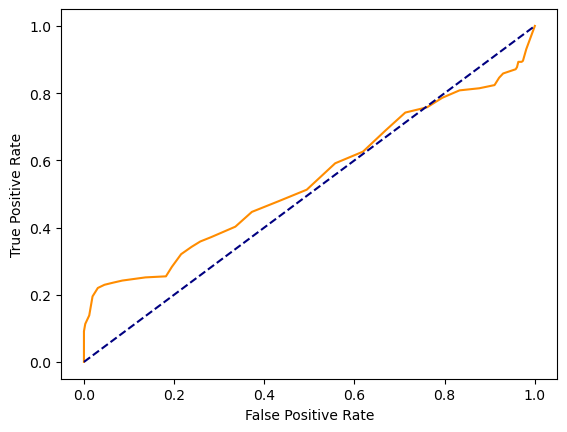

In [95]:
plt.plot(roc[0], roc[1], color="darkorange")
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")